# Algoritmo TCC

Este notebook foi executado no seguinte ambiente
* Python 3.7.X
* Jypyter Notebook 2.1.2
* pandas 1.0.3
* numpy 1.18.4

Antes de executar verifique os requisitos acima e descomprima o arquivo <code>datasets_consolidados.zip</code>.

In [94]:
import os

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Carrega arquivos originais de temperatura e log de servidores.

In [3]:
temp = pd.read_csv('datasets_consolidados/servidores-inlettemp.csv')
logs = pd.read_csv('datasets_consolidados/logs_servidores.csv')

Uma amostra das bases de logs e temperatura de servidores em estado original

In [4]:
temp

,Server,Average,Peak,Time
0,server01,21,22,Fri Dec 20 21:10:46 2013
1,server01,-128,-128,Fri Dec 20 22:10:46 2013
2,server01,-128,-128,Fri Dec 20 23:10:46 2013
3,server01,-128,-128,Sat Dec 21 00:10:46 2013
4,server01,-128,-128,Sat Dec 21 01:10:46 2013
...,...,...,...,...
1541371,server30,19,20,Thu Jan 2 06:01:57 2020
1541372,server30,19,20,Thu Jan 2 07:01:57 2020
1541373,server30,19,21,Thu Jan 2 08:01:57 2020
1541374,server30,18,21,Thu Jan 2 09:01:57 2020


In [5]:
logs

,Server,Severity,Date,Description
0,server01,Normal,Fri Dec 20 2013 20:15:46,Log cleared.
1,server01,Critical,Mon Mar 31 2014 14:24:53,The power input for power supply 2 is lost.
2,server01,Critical,Mon Mar 31 2014 14:25:04,Power supply redundancy is lost.
3,server01,Normal,Mon Mar 31 2014 13:29:08,The input power for power supply 2 has been re...
4,server01,Normal,Mon Mar 31 2014 13:29:13,The power supplies are redundant.
...,...,...,...,...
6363,server30,Critical,Tue May 21 2019 13:35:57,Power supply redundancy is lost.
6364,server30,Normal,Tue May 21 2019 20:05:01,The input power for power supply 2 has been re...
6365,server30,Normal,Tue May 21 2019 20:05:07,The power supplies are redundant.
6366,server30,Critical,Sun Jul 28 2019 06:42:53,The power input for power supply 1 is lost.


Remove as não-ocorrências de temperatura, ou seja, o servidor está desligado e isso é evidenciado com o atributo <code>Average</code> em -128.

In [58]:
temp.drop(temp.index[temp['Average'] == -128], inplace = True)

Transforma o atributo <code>Time</code> em tipo Date and cria um atributo <code>DateOnly</code> para posteriores comparações entre bases.

In [59]:
temp['Time']= pd.to_datetime(temp['Time'], format="%a %b %d %H:%M:%S %Y")
temp['DateOnly'] = temp['Time'].dt.date

Ordena a base de temperaturas em função do nome do servidor e do dia/hora.

In [60]:
temp = temp[ temp['Time'].dt.year >= 2013 ]

In [61]:
temp.sort_values(by=['Time'])

,Server,Average,Peak,Time,DateOnly
416640,server09,22,23,2013-12-20 18:43:19,2013-12-20
259572,server06,22,23,2013-12-20 18:46:57,2013-12-20
206664,server05,22,23,2013-12-20 18:57:58,2013-12-20
879816,server18,22,23,2013-12-20 19:01:40,2013-12-20
1183140,server24,23,25,2013-12-20 19:20:13,2013-12-20
...,...,...,...,...,...
1440453,server28,18,20,2020-01-09 04:10:39,2020-01-09
932662,server18,18,19,2020-01-09 05:03:05,2020-01-09
1440454,server28,18,19,2020-01-09 05:10:39,2020-01-09
932663,server18,18,19,2020-01-09 06:03:05,2020-01-09


Agrupa as linhas em função do nome de servidor e data, sumariza atráves do agrupamento os atributos <code>Average</code> e <code>Peak</code> com informações de Minímo, Máximo, Média, Mediana, Variância e Desvio Padrão.

In [62]:
temp_summary = temp.groupby(['Server','DateOnly'])[['Average','Peak']].agg(['min', 'max','mean','median','var','std']).reset_index()

A operação de groupby adiciona uma nova linha de indíces, pra isso é necessário realizar um ajuste para se manter uma só linha de índice sem perda de identidade das colunas.

In [63]:
temp_summary.columns = ["_".join(x) for x in temp_summary.columns.ravel()]
temp_summary.rename(columns={'Server_':'Server','DateOnly_':'DateOnly'},inplace=True)

Remove as ocorrências da base de logs aonde a data tem formato inválido pois indica o System Boot da máquina e transforma o atributo <code>Date</code> em tipo Date.

In [64]:
logs.drop(logs.index[logs['Date'] == 'System Boot'], inplace = True)
logs['LogTime']= pd.to_datetime(logs['Date'], format="%a %b %d %Y %H:%M:%S")

Cria o atributo <code>DateOnly</code> e orderna a base de logs em função do nome do servidor e o dia.

In [65]:
logs['DateOnly'] = logs['LogTime'].dt.date # creates a Date only column
logs.sort_values(by=['LogTime']) # make is sorted

,Server,Severity,Date,Description,Time,DateOnly,LogTime
1364,server07,Normal,Fri Dec 20 2013 13:43:57,Log cleared.,2013-12-20 13:43:57,2013-12-20,2013-12-20 13:43:57
5764,server28,Normal,Fri Dec 20 2013 13:47:25,Log cleared.,2013-12-20 13:47:25,2013-12-20,2013-12-20 13:47:25
5071,server25,Normal,Fri Dec 20 2013 14:12:20,Log cleared.,2013-12-20 14:12:20,2013-12-20,2013-12-20 14:12:20
683,server04,Normal,Fri Dec 20 2013 14:22:32,Log cleared.,2013-12-20 14:22:32,2013-12-20,2013-12-20 14:22:32
2550,server13,Normal,Fri Dec 20 2013 14:25:50,Log cleared.,2013-12-20 14:25:50,2013-12-20,2013-12-20 14:25:50
...,...,...,...,...,...,...,...
5760,server27,Normal,Thu Dec 19 2019 14:07:55,Drive 5 is installed in disk drive bay 1.,2019-12-19 14:07:55,2019-12-19,2019-12-19 14:07:55
5761,server27,Normal,Thu Dec 19 2019 14:08:12,Drive 4 is installed in disk drive bay 1.,2019-12-19 14:08:12,2019-12-19,2019-12-19 14:08:12
5762,server27,Normal,Thu Dec 19 2019 14:08:55,Drive 7 is installed in disk drive bay 1.,2019-12-19 14:08:55,2019-12-19,2019-12-19 14:08:55
5763,server27,Normal,Thu Dec 19 2019 14:09:07,Drive 6 is installed in disk drive bay 1.,2019-12-19 14:09:07,2019-12-19,2019-12-19 14:09:07


Combina as duas bases em uma só usando como índice o nome do servidor e o dia. Para cada ocorrência de log será concatenado os atributos de temperatura do servidor no dia.

In [66]:
#merged = pd.merge(logs, temp_summary, on=['Server', 'DateOnly'], validate = 'many_to_one') # merge two dataframes
#logs_server01 = logs[logs['Server']=='server01']
#temp_server01 = temp[temp['Server']=='server01']
#temp_server01.sort_values(by=['Time'])
#logs_server01.sort_values(by=['Date'])
#logs_server01.dropna()
#temp_server01.dropna()

In [67]:
merged = pd.merge_asof(logs.sort_values('LogTime'), temp.sort_values('Time'), left_on='LogTime', right_on='Time', by='Server', direction="nearest", tolerance=pd.Timedelta('3600000ms'), allow_exact_matches=False)

Adiciona o atributo categórico <code>TempSala</code> que indica se a sala de servidores estava quente, esquentando ou fria.

In [68]:
merged

,Server,Severity,Date,Description,Time_x,DateOnly_x,LogTime,Average,Peak,Time_y,DateOnly_y
0,server07,Normal,Fri Dec 20 2013 13:43:57,Log cleared.,2013-12-20 13:43:57,2013-12-20,2013-12-20 13:43:57,NaN,NaN,NaT,NaN
1,server28,Normal,Fri Dec 20 2013 13:47:25,Log cleared.,2013-12-20 13:47:25,2013-12-20,2013-12-20 13:47:25,NaN,NaN,NaT,NaN
2,server25,Normal,Fri Dec 20 2013 14:12:20,Log cleared.,2013-12-20 14:12:20,2013-12-20,2013-12-20 14:12:20,NaN,NaN,NaT,NaN
3,server04,Normal,Fri Dec 20 2013 14:22:32,Log cleared.,2013-12-20 14:22:32,2013-12-20,2013-12-20 14:22:32,NaN,NaN,NaT,NaN
4,server13,Normal,Fri Dec 20 2013 14:25:50,Log cleared.,2013-12-20 14:25:50,2013-12-20,2013-12-20 14:25:50,NaN,NaN,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...
6302,server27,Normal,Thu Dec 19 2019 14:07:55,Drive 5 is installed in disk drive bay 1.,2019-12-19 14:07:55,2019-12-19,2019-12-19 14:07:55,21.0,22.0,2019-12-19 14:11:41,2019-12-19
6303,server27,Normal,Thu Dec 19 2019 14:08:12,Drive 4 is installed in disk drive bay 1.,2019-12-19 14:08:12,2019-12-19,2019-12-19 14:08:12,21.0,22.0,2019-12-19 14:11:41,2019-12-19
6304,server27,Normal,Thu Dec 19 2019 14:08:55,Drive 7 is installed in disk drive bay 1.,2019-12-19 14:08:55,2019-12-19,2019-12-19 14:08:55,21.0,22.0,2019-12-19 14:11:41,2019-12-19
6305,server27,Normal,Thu Dec 19 2019 14:09:07,Drive 6 is installed in disk drive bay 1.,2019-12-19 14:09:07,2019-12-19,2019-12-19 14:09:07,21.0,22.0,2019-12-19 14:11:41,2019-12-19


In [69]:
merged.dropna(inplace=True)

In [70]:
merged.loc[merged['Peak'] <= 26, 'TempSala'] = 'SalaFria'
merged.loc[(merged['Peak'] > 26) & (merged['Peak'] <= 33), 'TempSala'] = 'SalaEsquentando'
merged.loc[merged['Peak'] > 33, 'TempSala'] = 'SalaQuente'

Amostra da base combinada

In [71]:
merged

,Server,Severity,Date,Description,Time_x,DateOnly_x,LogTime,Average,Peak,Time_y,DateOnly_y,TempSala
12,server09,Normal,Fri Dec 20 2013 17:48:21,Log cleared.,2013-12-20 17:48:21,2013-12-20,2013-12-20 17:48:21,22.0,23.0,2013-12-20 18:43:19,2013-12-20,SalaFria
13,server06,Normal,Fri Dec 20 2013 17:52:02,Log cleared.,2013-12-20 17:52:02,2013-12-20,2013-12-20 17:52:02,22.0,23.0,2013-12-20 18:46:57,2013-12-20,SalaFria
14,server05,Normal,Fri Dec 20 2013 18:03:04,Log cleared.,2013-12-20 18:03:04,2013-12-20,2013-12-20 18:03:04,22.0,23.0,2013-12-20 18:57:58,2013-12-20,SalaFria
15,server18,Normal,Fri Dec 20 2013 18:06:44,Log cleared.,2013-12-20 18:06:44,2013-12-20,2013-12-20 18:06:44,22.0,23.0,2013-12-20 19:01:40,2013-12-20,SalaFria
16,server10,Normal,Fri Dec 20 2013 18:39:42,Log cleared.,2013-12-20 18:39:42,2013-12-20,2013-12-20 18:39:42,22.0,23.0,2013-12-20 19:34:43,2013-12-20,SalaFria
...,...,...,...,...,...,...,...,...,...,...,...,...
6301,server17,Normal,Thu Dec 19 2019 14:05:59,Drive 6 is installed in disk drive bay 1.,2019-12-19 14:05:59,2019-12-19,2019-12-19 14:05:59,20.0,22.0,2019-12-19 14:11:53,2019-12-19,SalaFria
6302,server27,Normal,Thu Dec 19 2019 14:07:55,Drive 5 is installed in disk drive bay 1.,2019-12-19 14:07:55,2019-12-19,2019-12-19 14:07:55,21.0,22.0,2019-12-19 14:11:41,2019-12-19,SalaFria
6303,server27,Normal,Thu Dec 19 2019 14:08:12,Drive 4 is installed in disk drive bay 1.,2019-12-19 14:08:12,2019-12-19,2019-12-19 14:08:12,21.0,22.0,2019-12-19 14:11:41,2019-12-19,SalaFria
6304,server27,Normal,Thu Dec 19 2019 14:08:55,Drive 7 is installed in disk drive bay 1.,2019-12-19 14:08:55,2019-12-19,2019-12-19 14:08:55,21.0,22.0,2019-12-19 14:11:41,2019-12-19,SalaFria


O atributo <code>Severity</code> será útil ao executar alguns modelos como o PCA na base merged, mas a maioria dos modelos requer que atributos categoricos sejam transformados em inteiros. Para isso, utilizaremos a técnica de One-Hot Encoding para isso.

Abaixo podemos visualizar os possíveis valores para <code>Severity</code>.

In [72]:
merged.Severity.unique()

array(['Normal', 'Critical', 'Warning'], dtype=object)

In [73]:
merged[merged['Severity'] == 'Critical']

,Server,Severity,Date,Description,Time_x,DateOnly_x,LogTime,Average,Peak,Time_y,DateOnly_y,TempSala
327,server23,Critical,Mon Mar 31 2014 18:05:38,The power input for power supply 2 is lost.,2014-03-31 18:05:38,2014-03-31,2014-03-31 18:05:38,28.0,30.0,2014-03-31 18:21:43,2014-03-31,SalaEsquentando
328,server23,Critical,Mon Mar 31 2014 18:05:49,Power supply redundancy is lost.,2014-03-31 18:05:49,2014-03-31,2014-03-31 18:05:49,28.0,30.0,2014-03-31 18:21:43,2014-03-31,SalaEsquentando
336,server21,Critical,Mon Mar 31 2014 19:04:54,The power input for power supply 2 is lost.,2014-03-31 19:04:54,2014-03-31,2014-03-31 19:04:54,25.0,31.0,2014-03-31 18:38:52,2014-03-31,SalaEsquentando
337,server21,Critical,Mon Mar 31 2014 19:04:55,Power supply redundancy is lost.,2014-03-31 19:04:55,2014-03-31,2014-03-31 19:04:55,25.0,31.0,2014-03-31 18:38:52,2014-03-31,SalaEsquentando
340,server06,Critical,Mon Mar 31 2014 19:05:31,The power input for power supply 2 is lost.,2014-03-31 19:05:31,2014-03-31,2014-03-31 19:05:31,18.0,21.0,2014-03-31 18:47:01,2014-03-31,SalaFria
...,...,...,...,...,...,...,...,...,...,...,...,...
6293,server27,Critical,Thu Dec 19 2019 13:58:49,Drive 4 is removed from disk drive bay 1.,2019-12-19 13:58:49,2019-12-19,2019-12-19 13:58:49,21.0,22.0,2019-12-19 14:11:41,2019-12-19,SalaFria
6295,server27,Critical,Thu Dec 19 2019 14:00:35,Drive 6 is removed from disk drive bay 1.,2019-12-19 14:00:35,2019-12-19,2019-12-19 14:00:35,21.0,22.0,2019-12-19 14:11:41,2019-12-19,SalaFria
6297,server27,Critical,Thu Dec 19 2019 14:00:38,Drive 7 is removed from disk drive bay 1.,2019-12-19 14:00:38,2019-12-19,2019-12-19 14:00:38,21.0,22.0,2019-12-19 14:11:41,2019-12-19,SalaFria
6298,server27,Critical,Thu Dec 19 2019 14:00:44,Drive 3 is removed from disk drive bay 1.,2019-12-19 14:00:44,2019-12-19,2019-12-19 14:00:44,21.0,22.0,2019-12-19 14:11:41,2019-12-19,SalaFria


Cria-se um dataset com os valores possíveis e utilizamos a função pd.get_dummies() para gerar as colunas numéricas.

,Average,Peak,Severity_Critical,Severity_Normal,Severity_Warning
Average,129.888645,147.304911,-1.349312,-0.379000,1.728312
Peak,147.304911,178.496015,-1.683645,-0.676025,2.359670
Severity_Critical,-1.349312,-1.683645,0.244272,-0.155217,-0.089055
Severity_Normal,-0.379000,-0.676025,-0.155217,0.232103,-0.076886
Severity_Warning,1.728312,2.359670,-0.089055,-0.076886,0.165940


,Average,Peak,Severity_Critical,Severity_Normal,Severity_Warning
Average,1.000000,0.967425,-0.239547,-0.069026,0.372272
Peak,0.967425,1.000000,-0.254976,-0.105029,0.433572
Severity_Critical,-0.239547,-0.254976,1.000000,-0.651873,-0.442327
Severity_Normal,-0.069026,-0.105029,-0.651873,1.000000,-0.391768
Severity_Warning,0.372272,0.433572,-0.442327,-0.391768,1.000000


In [74]:
df = pd.DataFrame({'Severity': ['Normal', 'Critical', 'Warning']})
merged = pd.concat([merged,pd.get_dummies(merged['Severity'], prefix='Severity')],axis=1)

Uma amostra dos novos atributos.

In [75]:
merged.filter(regex=("Severity_*"))

,Severity,Severity_Critical,Severity_Normal,Severity_Warning
12,Normal,0,1,0
13,Normal,0,1,0
14,Normal,0,1,0
15,Normal,0,1,0
16,Normal,0,1,0
...,...,...,...,...
6301,Normal,0,1,0
6302,Normal,0,1,0
6303,Normal,0,1,0
6304,Normal,0,1,0


Exporta as bases para CSV

In [76]:
temp.to_csv(r'datasets_consolidados/temperatura.csv', index = False) # export all datasets
logs.to_csv(r'datasets_consolidados/logs.csv', index = False)
merged.to_csv(r'datasets_consolidados/merged.csv', index = False)

## Avaliando dados com PCA

Frequência de atributos importantes

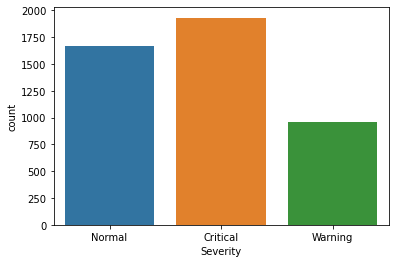

In [77]:
import seaborn as sns
Severity = sns.countplot(merged['Severity'])

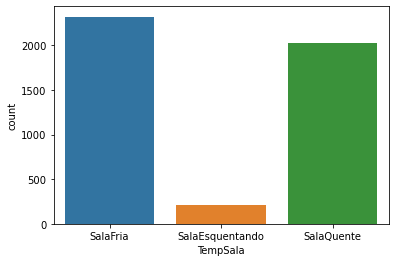

In [78]:
TempSala = sns.countplot(merged['TempSala'])

In [79]:
len(merged[(merged['Severity']== 'Normal') & (merged['TempSala']=='SalaQuente')])

638

In [80]:
len(merged[(merged['Severity']== 'Warning') & (merged['TempSala']=='SalaQuente')])

891

In [81]:
len(merged[(merged['Severity']== 'Critical') & (merged['TempSala']=='SalaQuente')])

498

In [93]:
merged.cov()

,Average,Peak,Severity_Critical,Severity_Normal,Severity_Warning
Average,129.888645,147.304911,-1.349312,-0.379000,1.728312
Peak,147.304911,178.496015,-1.683645,-0.676025,2.359670
Severity_Critical,-1.349312,-1.683645,0.244272,-0.155217,-0.089055
Severity_Normal,-0.379000,-0.676025,-0.155217,0.232103,-0.076886
Severity_Warning,1.728312,2.359670,-0.089055,-0.076886,0.165940


Usando a temperatura Média (min/max) e Picos (min/max) como features e normalizando os valores

In [46]:
features = ['Average','Peak']
# Separating out the features
x = merged.loc[:, features].values
# Separating out the target
y = merged.loc[:,['Severity']].values

#x = StandardScaler().fit_transform(x)
pd.DataFrame(data = x, columns = features).head()

,Average,Peak
0,22.0,23.0
1,22.0,23.0
2,22.0,23.0
3,22.0,23.0
4,22.0,23.0


In [47]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Executar o PCA

In [48]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.head(5)

,principal component 1,principal component 2
0,-12.699194,-1.606452
1,-12.699194,-1.606452
2,-12.699194,-1.606452
3,-12.699194,-1.606452
4,-12.699194,-1.606452


Dataset com os componentes e o target

In [49]:
finalDf = pd.concat([principalDf, merged[['Severity']]], axis = 1)
finalDf.head(5)

,principal component 1,principal component 2,Severity
0,-12.699194,-1.606452,NaN
1,-12.699194,-1.606452,NaN
2,-12.699194,-1.606452,NaN
3,-12.699194,-1.606452,NaN
4,-12.699194,-1.606452,NaN


Plotando o gráfico

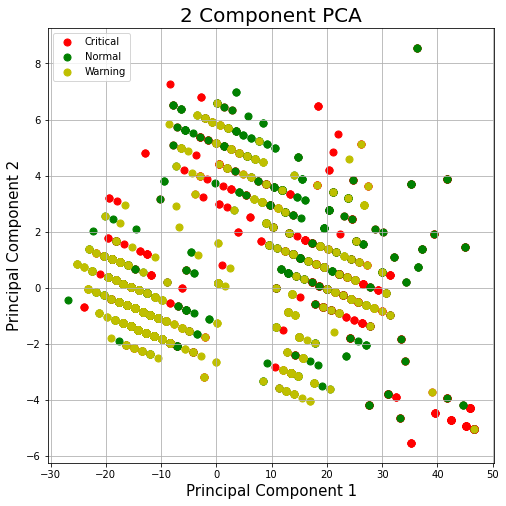

In [50]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)


targets = ['Critical', 'Normal', 'Warning']
colors = ['r', 'g', 'y']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Severity'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

Criando base de treino e teste 70% treino e 30% teste

In [51]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

Normaliza os atributos

In [52]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Roda o classificador de árvore de decisão.

In [53]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
y_pred

array(['Critical', 'Critical', 'Critical', ..., 'Normal', 'Critical',
       'Warning'], dtype=object)

In [54]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.48391812865497075


Matrix de confusão

In [55]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[386, 126,  67],
       [232, 147, 114],
       [ 99,  68, 129]], dtype=int64)